In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

path = "C:\\Users\\Nathan\\Desktop\\Guttenberg Gait Database\\"

# Left 
GRF_F_V_PRO_left = pd.read_csv(os.path.join(path,'GRF_F_V_PRO_left.csv'))
GRF_F_AP_PRO_left = pd.read_csv(os.path.join(path,'GRF_F_AP_PRO_left.csv'))
GRF_F_ML_PRO_left = pd.read_csv(os.path.join(path,'GRF_F_ML_PRO_left.csv'))

# Right lower extremity
GRF_F_V_PRO_right = pd.read_csv(os.path.join(path,'GRF_F_V_PRO_right.csv'))
GRF_F_AP_PRO_right = pd.read_csv(os.path.join(path,'GRF_F_AP_PRO_right.csv'))
GRF_F_ML_PRO_right = pd.read_csv(os.path.join(path,'GRF_F_ML_PRO_right.csv'))

In [12]:
def TransformDataFrame(DataFrame):
    DataFrame = DataFrame.drop(['DATASET_ID', 'SUBJECT_ID', 'SESSION_ID', 'TRIAL_ID'], axis = 1)
    DataFrame = DataFrame.T
    return DataFrame

def SelectSuject(ID, DataLeft, DataRight):
    DataSubjectLeft = DataLeft[DataLeft['SUBJECT_ID'] == ID]
    DataSubjectRight = DataRight[DataRight['SUBJECT_ID'] == ID]
    DataSubjectLeft = TransformDataFrame(DataSubjectLeft)
    DataSubjectRight = TransformDataFrame(DataSubjectRight)
    return DataSubjectLeft, DataSubjectRight

def MeanData(DataLeft, DataRight):
     MeanData = pd.DataFrame()
     MeanData["Left"] =  DataLeft.mean(axis = 1)
     MeanData["Right"] = DataRight.mean(axis = 1)
     return  MeanData["Left"], MeanData["Right"]

def TabGrfTotal(DataSubjectLeft, DataSubjectRight, decalage):
    GrfRight = [-999]
    GrfLeft = [-999]

    SwingLeft = [0] * (100 - (2 *decalage))
    SwingRight = [0] * (100 - (2 *decalage))
    
    for col in zip(DataSubjectLeft.columns, DataSubjectRight.columns):
        GrfLeft = np.concatenate((GrfLeft, DataSubjectLeft[col[0]], SwingLeft), axis = 0)
        GrfRight = np.concatenate((GrfRight, DataSubjectRight[col[1]], SwingRight), axis = 0)

    GrfLeft = GrfLeft[1:]
    GrfRight = GrfRight[1:]
    GrfLeft = GrfLeft[(100 - decalage):]
    GrfRight = GrfRight[ : (len(GrfRight)-(100 - decalage))]
    GrfLeft[:decalage+10] = 0
    GrfRight[-decalage - 102:] = 0
    GrfRight[0] = 0
    
    return GrfLeft, GrfRight

def ConcatenanteGrfTotal(DataSubjectLeft, DataSubjectRight):
    GrfRight = [-999]
    GrfLeft = [-999]
    
    for col in zip(DataSubjectLeft.columns, DataSubjectRight.columns):
        GrfLeft = np.concatenate((GrfLeft, DataSubjectLeft[col[0]]), axis = 0)
        GrfRight = np.concatenate((GrfRight, DataSubjectRight[col[1]]), axis = 0)

    GrfLeft = GrfLeft[1:]
    GrfRight = GrfRight[1:]
    
    return GrfLeft, GrfRight

Si on veut faire du traitement avec tous les pas avec un décalage de temps entre chaque pas cf : 
- attention ça coupe le premier et dernier donc ça fait planter certains codes

In [3]:
""" Choix du patient avec ID puis importation des data depuis la base de donnée de Guttenberg """
ID = 1
decalage_entre_deux_pas = 15

VerticalGrfLeft, VerticalGrfRight = SelectSuject(ID, DataLeft = GRF_F_V_PRO_left, DataRight = GRF_F_V_PRO_right)
VerticalGrfLeft, VerticalGrfRight = TabGrfTotal(DataSubjectLeft = VerticalGrfLeft, DataSubjectRight = VerticalGrfRight, decalage = decalage_entre_deux_pas)

ApGrfLeft, ApGrfRight = SelectSuject(ID, DataLeft = GRF_F_AP_PRO_left, DataRight = GRF_F_AP_PRO_right)
ApGrfLeft, ApGrfRight = TabGrfTotal(DataSubjectLeft = ApGrfLeft, DataSubjectRight = ApGrfRight, decalage = decalage_entre_deux_pas)

MediolateralGrfLeft, MediolateralGrfRight = SelectSuject(ID, DataLeft = GRF_F_ML_PRO_left, DataRight = GRF_F_ML_PRO_right)
MediolateralGrfLeft, MediolateralGrfRight = TabGrfTotal(DataSubjectLeft = MediolateralGrfLeft, DataSubjectRight = MediolateralGrfRight, decalage = decalage_entre_deux_pas)


""" Création et implémentation de l'objet Walking avec des semelles """
# from semelle_connecte.SOLE.FeetMe import FeetMe
# from semelle_connecte.Walking.Walking import Walking
from SOLE.FeetMe import FeetMe
from Walking.Walking import Walking

dataLeft = pd.DataFrame()
# VerticalGrfLeft = np.concatenate([VerticalGrfLeft[:-200], [0] * len(VerticalGrfLeft[-200:])])  #### pour créer un pas en moins à gauche
dataLeft["VerticalVGrf"] = VerticalGrfLeft
dataLeft["ApGrf"] = ApGrfLeft
dataLeft["MediolateralGrf"] = MediolateralGrfLeft

SoleInstanceLeft = FeetMe(100)
SoleInstanceLeft.SetGroundReactionForce("Vertical", dataLeft["VerticalVGrf"].to_numpy())
SoleInstanceLeft.SetGroundReactionForce("Ap", dataLeft["ApGrf"].to_numpy())
SoleInstanceLeft.SetGroundReactionForce("Mediolateral", dataLeft["MediolateralGrf"].to_numpy())
SoleInstanceLeft.constructTimeseries()


dataRight = pd.DataFrame()
dataRight["VerticalVGrf"] = VerticalGrfRight
dataRight["ApGrf"] = ApGrfRight
dataRight["MediolateralGrf"] = MediolateralGrfRight

SoleInstanceRight = FeetMe(100)
SoleInstanceRight.SetGroundReactionForce("Vertical", dataRight["VerticalVGrf"].to_numpy())
SoleInstanceRight.SetGroundReactionForce("Ap", dataRight["ApGrf"].to_numpy())
SoleInstanceRight.SetGroundReactionForce("Mediolateral", dataRight["MediolateralGrf"].to_numpy())
SoleInstanceRight.constructTimeseries()

walking = Walking(mass=90)
walking.setLeftLegSole(SoleInstanceLeft)
walking.setRightLegSole(SoleInstanceRight)

2023-05-10 18:25:29,810 - [ERROR] - pyCGM2 - (__init__.py).<module>(63) - EMG_CHANNELS is empty 


Représente la Grf total d'un pas droit puis gauche et d'un pas gauche puis droit.

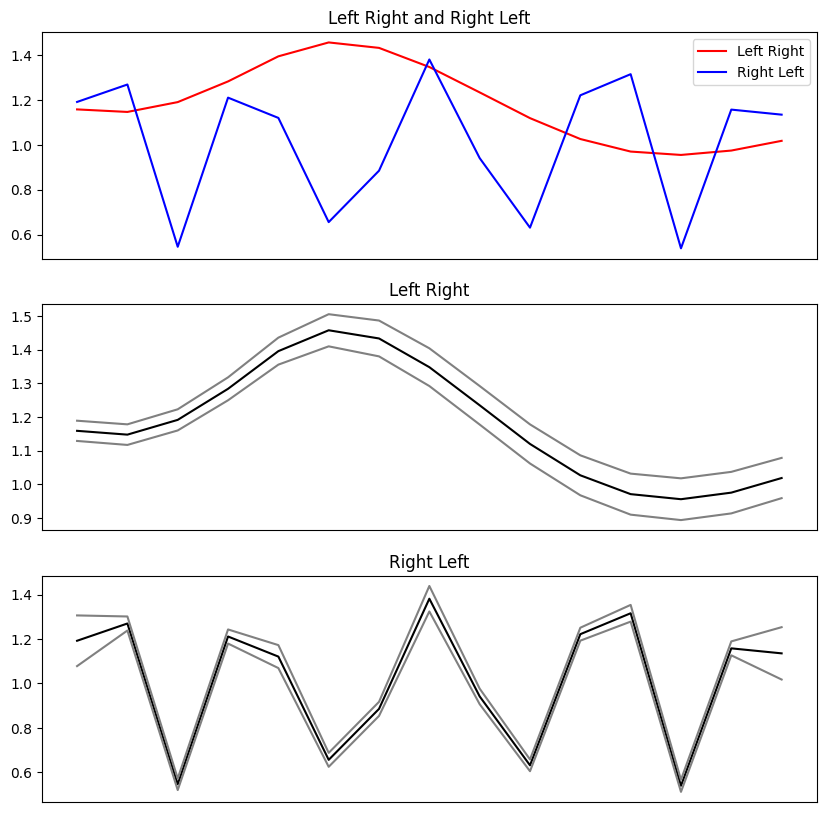

In [4]:
from Walking.WalkingFilters import WalkingKinematicsFilter, WalkingGraphicsFilter
from Walking.WalkingKinematicsProcedure import TwoStepProcedure
from Walking.WalkingGraphicsProcedure import PlotTwoStepProcedure

procedure = TwoStepProcedure()
WalkingKinematicsFilter(walking, procedure).run()

procedure = PlotTwoStepProcedure()
WalkingGraphicsFilter(walking, procedure).run()

Si on veut faire du traitement avec tous les pas sans décalage de temps entre chaque pas cf : 
- évite de couper le premier et dernier pas

In [5]:
""" Choix du patient avec ID puis importation des data depuis la base de donnée de Guttenberg """
ID = 1
decalage_entre_deux_pas = 15

VerticalGrfLeft, VerticalGrfRight = SelectSuject(ID, DataLeft = GRF_F_V_PRO_left, DataRight = GRF_F_V_PRO_right)
VerticalGrfLeft, VerticalGrfRight = ConcatenanteGrfTotal(DataSubjectLeft = VerticalGrfLeft, DataSubjectRight = VerticalGrfRight)

ApGrfLeft, ApGrfRight = SelectSuject(ID, DataLeft = GRF_F_AP_PRO_left, DataRight = GRF_F_AP_PRO_right)
ApGrfLeft, ApGrfRight = ConcatenanteGrfTotal(DataSubjectLeft = ApGrfLeft, DataSubjectRight = ApGrfRight)

MediolateralGrfLeft, MediolateralGrfRight = SelectSuject(ID, DataLeft = GRF_F_ML_PRO_left, DataRight = GRF_F_ML_PRO_right)
MediolateralGrfLeft, MediolateralGrfRight = ConcatenanteGrfTotal(DataSubjectLeft = MediolateralGrfLeft, DataSubjectRight = MediolateralGrfRight)


""" Création et implémentation de l'objet Walking avec des semelles """
# from semelle_connecte.SOLE.FeetMe import FeetMe
# from semelle_connecte.Walking.Walking import Walking
from SOLE.FeetMe import FeetMe
from Walking.Walking import Walking

dataLeft = pd.DataFrame()
dataLeft["VerticalVGrf"] = VerticalGrfLeft
dataLeft["ApGrf"] = ApGrfLeft
dataLeft["MediolateralGrf"] = MediolateralGrfLeft

SoleInstanceLeft = FeetMe(100)
SoleInstanceLeft.SetGroundReactionForce("Vertical", dataLeft["VerticalVGrf"].to_numpy())
SoleInstanceLeft.SetGroundReactionForce("Ap", dataLeft["ApGrf"].to_numpy())
SoleInstanceLeft.SetGroundReactionForce("Mediolateral", dataLeft["MediolateralGrf"].to_numpy())
SoleInstanceLeft.constructTimeseries()


dataRight = pd.DataFrame()
dataRight["VerticalVGrf"] = VerticalGrfRight
dataRight["ApGrf"] = ApGrfRight
dataRight["MediolateralGrf"] = MediolateralGrfRight

SoleInstanceRight = FeetMe(100)
SoleInstanceRight.SetGroundReactionForce("Vertical", dataRight["VerticalVGrf"].to_numpy())
SoleInstanceRight.SetGroundReactionForce("Ap", dataRight["ApGrf"].to_numpy())
SoleInstanceRight.SetGroundReactionForce("Mediolateral", dataRight["MediolateralGrf"].to_numpy())
SoleInstanceRight.constructTimeseries()

walking = Walking(mass=90)
walking.setLeftLegSole(SoleInstanceLeft)
walking.setRightLegSole(SoleInstanceRight)

In [6]:
from Walking.WalkingFilters import WalkingKinematicsFilter
from Walking.WalkingKinematicsProcedure import GroundReactionForceKinematicsProcedure

procedure = GroundReactionForceKinematicsProcedure()
WalkingKinematicsFilter(walking, procedure).run()

Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.0370644395416493
Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.03706500592814591


Normalisation des forces de réactions au sol de chaque pas en % de cycle et en % de poids du corps

In [7]:
from Walking.WalkingFilters import WalkingDataProcessingFilter
from Walking.WalkingDataProcessingProcedure import NormalisationProcedure

procedure = NormalisationProcedure()
WalkingDataProcessingFilter(walking, procedure).run()

#du coup je relance les calculs des valeurs sur les donnés normalisés
procedure = GroundReactionForceKinematicsProcedure()
WalkingKinematicsFilter(walking, procedure).run()

Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.0370644395416493
Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.03706500592814591


Visualisation des datas trouvés par la procédure GroundReactionForceKinematicsProcedure() sur les GRF correspondantes :

In [ ]:
for stepindex in [1,10,20,30,40] :
# for stepindex in np.arange(len(walking.m_StepGrfValue['LeftLeg']['VerticalGrf']) - 1) : # plot tout les pas avec les data trouvés
    """ Visualisation des valeurs retrouvées par GroundReactionForceKinematicsProcedure() """
    FrameRate = 10
    step = stepindex
    print(f"Pas numéro {step}")

    """ Vertical Ground Reaction Force Data """ 

    FirstPeak = walking.m_GroundReactionForces["LeftLeg"][step][0]
    MidstanceValley = walking.m_GroundReactionForces["LeftLeg"][step][1]
    SecondPeak = walking.m_GroundReactionForces["LeftLeg"][step][2]
    FirtPeakTimeTo = walking.m_GroundReactionForces["LeftLeg"][step][3] * FrameRate
    MidstanceValleyTimeTo = walking.m_GroundReactionForces["LeftLeg"][step][4] * FrameRate
    SecondPeakTimeTo = walking.m_GroundReactionForces["LeftLeg"][step][5] * FrameRate
    TimeFromMidstanceValleyToToeOff = walking.m_GroundReactionForces["LeftLeg"][step][6] * FrameRate

    plt.plot(walking.m_StepGrfValue['LeftLeg']['VerticalGrf'][step])
    plt.scatter(x=FirtPeakTimeTo ,y=FirstPeak, c ="r", label="FirstPeak")
    plt.scatter(x=SecondPeakTimeTo ,y=SecondPeak, c="g", label="SecondPeak")
    plt.scatter(x=MidstanceValleyTimeTo ,y=MidstanceValley, c="b", label="MidstanceValley")
    plt.hlines(y=MidstanceValley, xmin=MidstanceValleyTimeTo, xmax=TimeFromMidstanceValleyToToeOff+MidstanceValleyTimeTo,
            colors ="r", ls="--", label='TimeFromMidstanceValleyToToeOff')
    plt.legend()
    plt.show()


    """ Ant-Post Ground Reaction Force Data """
    BrakingPeak = walking.m_GroundReactionForces["LeftLeg"][step][10]
    PropulsivePeak = walking.m_GroundReactionForces["LeftLeg"][step][11]
    BrakePhaseDuration = walking.m_GroundReactionForces["LeftLeg"][step][12] * FrameRate
    PropulsivePhaseDuration = walking.m_GroundReactionForces["LeftLeg"][step][13] * FrameRate
    BrakePhaseTimeTo = walking.m_GroundReactionForces["LeftLeg"][step][14] * FrameRate
    PropulsivePhaseTimeTo = walking.m_GroundReactionForces["LeftLeg"][step][15] * FrameRate

    plt.plot(walking.m_StepGrfValue['LeftLeg']['ApGrf'][step])
    plt.scatter(x= BrakePhaseTimeTo, y=BrakingPeak, c="r", label='BrakingPeak')
    plt.scatter(x= PropulsivePhaseTimeTo + BrakePhaseDuration, y=PropulsivePeak, c="g", label='PropulsivePeak')
    plt.hlines(y=0, xmin=0, xmax=102, colors ="black", ls="--")
    plt.hlines(y=0, xmin=0, xmax=BrakePhaseDuration, colors ="r", ls="--", label='BrakePhaseDuration')
    plt.hlines(y=0, xmin=BrakePhaseDuration, xmax=BrakePhaseDuration + PropulsivePhaseDuration, colors ="g", ls="--", label='PropulsivePhaseDuration')
    plt.legend()
    plt.show()

In [ ]:
FirtAndMidstanceImpulse = []
SecondAndPreswingImpulse = []
TotalVerticalGrfImpulse = []

for step in np.arange(len(walking.m_GroundReactionForces["LeftLeg"]) - 1):
    FirtAndMidstanceImpulse.append(walking.m_GroundReactionForces["LeftLeg"][step][7])
    SecondAndPreswingImpulse.append(walking.m_GroundReactionForces["LeftLeg"][step][8])
    TotalVerticalGrfImpulse.append(walking.m_GroundReactionForces["LeftLeg"][step][9])

plt.figure()
plt.plot(FirtAndMidstanceImpulse, label="FirtAndMidstanceImpulse")
plt.plot(SecondAndPreswingImpulse, label='SecondAndPreswingImpulse')
plt.plot(TotalVerticalGrfImpulse, label="TotalVerticalGrfImpulse")
plt.legend()
plt.show()

Montre les pas les plus et les moins asymétriques pour chaques paramètres de la marche

In [ ]:
from Walking.WalkingFilters import WalkingKinematicsFilter
from Walking.WalkingKinematicsProcedure import DynamicSymetryFunctionComputeProcedure
from Walking.WalkingGraphicsProcedure import PlotMaxAndMinAsymetryProcedure
from Walking.WalkingFilters import WalkingGraphicsFilter

procedure = DynamicSymetryFunctionComputeProcedure()
WalkingKinematicsFilter(walking, procedure).run()
procedure = PlotMaxAndMinAsymetryProcedure()
WalkingGraphicsFilter(walking, procedure).run()

Cherche les pas les plus et moins asymétriques pour l'ensemble des paramètres

In [ ]:
from Walking.WalkingFilters import WalkingDataProcessingFilter, WalkingKinematicsFilter
from Walking.WalkingDataProcessingProcedure import NormalisationProcedure
from Walking.WalkingKinematicsProcedure import DynamicSymetryFunctionComputeProcedure
from Walking.WalkingGraphicsProcedure import PlotWorthAndBestStepProcedure

procedure = NormalisationProcedure()
WalkingDataProcessingFilter(walking, procedure).run()
procedure = GroundReactionForceKinematicsProcedure()
WalkingKinematicsFilter(walking, procedure).run()
procedure = DynamicSymetryFunctionComputeProcedure()
WalkingKinematicsFilter(walking, procedure).run()
procedure = PlotWorthAndBestStepProcedure()
WalkingGraphicsFilter(walking, procedure).run()

Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.0370644395416493
Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.03706500592814591
Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.0370644395416493
Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.03706500592814591
Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.0370644395416493
Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.03706500592814591
Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.03706935585237652
Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.03706835169859531
Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.03762247953700001
Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.03761779428140496
Caution no 0 find in Vertical GRF dataframe : use of a thresfold at 0.03761720429372469
Caution no 0 find in Vertical GRF d

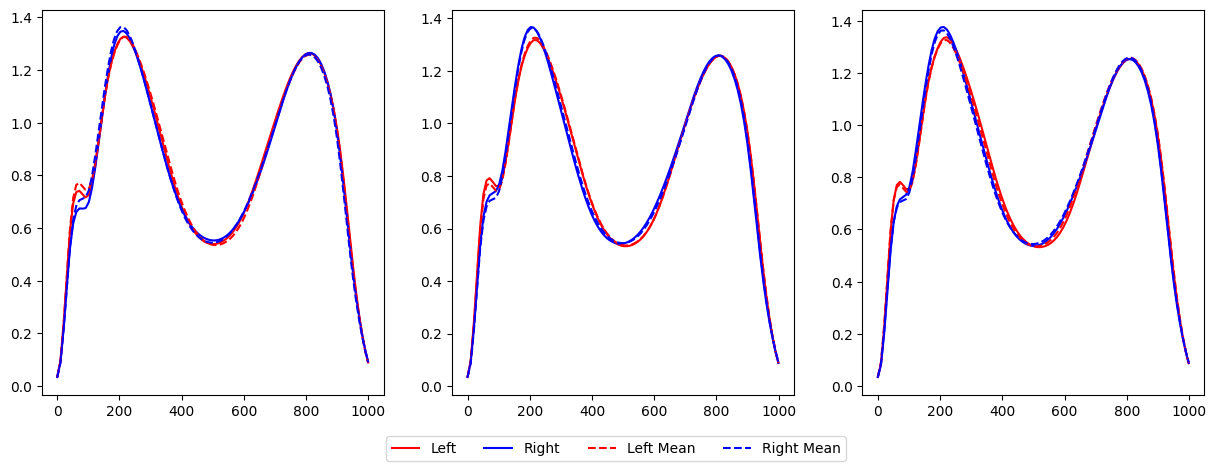

In [10]:
from Walking.WalkingFilters import WalkingDataProcessingFilter
from Walking.WalkingDataProcessingProcedure import CutDataProcessingProcedure

procedure = CutDataProcessingProcedure()
procedure.setCutNumber(n_cut=3)
WalkingDataProcessingFilter(walking, procedure).run()

from Walking.WalkingFilters import WalkingGraphicsFilter
from Walking.WalkingGraphicsProcedure import PlotCutGroundReactionForceProcedure

procedure = PlotCutGroundReactionForceProcedure()
WalkingGraphicsFilter(walking, procedure).run()

Si on veut qu'une valeur moyenne des pas cf :

In [15]:
ID = 1
decalage_entre_deux_pas = 15

VerticalGrfLeft, VerticalGrfRight = SelectSuject(ID, DataLeft = GRF_F_V_PRO_left, DataRight = GRF_F_V_PRO_right)
VerticalGrfLeft, VerticalGrfRight = MeanData(DataLeft = VerticalGrfLeft, DataRight = VerticalGrfRight)

ApGrfLeft, ApGrfRight = SelectSuject(ID, DataLeft = GRF_F_AP_PRO_left, DataRight = GRF_F_AP_PRO_right)
ApGrfLeft, ApGrfRight  = MeanData(DataLeft = ApGrfLeft, DataRight = ApGrfRight)

MediolateralGrfLeft, MediolateralGrfRight = SelectSuject(ID, DataLeft = GRF_F_ML_PRO_left, DataRight = GRF_F_ML_PRO_right)
MediolateralGrfLeft, MediolateralGrfRight = MeanData(DataLeft = MediolateralGrfLeft, DataRight = MediolateralGrfRight)

In [16]:
# from semelle_connecte.SOLE.FeetMe import FeetMe
# from semelle_connecte.Walking.Walking import Walking
from SOLE.FeetMe import FeetMe
from Walking.Walking import Walking

dataLeft = pd.DataFrame()
dataLeft["VerticalVGrf"] = VerticalGrfLeft.values
dataLeft["ApGrf"] = ApGrfLeft.values
dataLeft["MediolateralGrf"] = MediolateralGrfLeft.values

SoleInstanceLeft = FeetMe(100)
SoleInstanceLeft.SetGroundReactionForce("Vertical", dataLeft["VerticalVGrf"].to_numpy())
SoleInstanceLeft.SetGroundReactionForce("Ap", dataLeft["ApGrf"].to_numpy())
SoleInstanceLeft.SetGroundReactionForce("Mediolateral", dataLeft["MediolateralGrf"].to_numpy())
SoleInstanceLeft.constructTimeseries()


dataRight = pd.DataFrame()
dataRight["VerticalVGrf"] = VerticalGrfRight.values
dataRight["ApGrf"] = ApGrfRight.values
dataRight["MediolateralGrf"] = MediolateralGrfRight.values

SoleInstanceRight = FeetMe(100)
SoleInstanceRight.SetGroundReactionForce("Vertical", dataRight["VerticalVGrf"].to_numpy())
SoleInstanceRight.SetGroundReactionForce("Ap", dataRight["ApGrf"].to_numpy())
SoleInstanceRight.SetGroundReactionForce("Mediolateral", dataRight["MediolateralGrf"].to_numpy())
SoleInstanceRight.constructTimeseries()

walking = Walking(mass=90)
walking.setLeftLegSole(SoleInstanceLeft)
walking.setRightLegSole(SoleInstanceRight)

Représenter l'asymétrie d'un pas moyen droit par rapport au gauche dans les trois axes :
- PlotDynamicSymetryFunctionRealtimeProcedure : en temps réel
- PlotDynamicSymetryFunctionNormalised : sur % du cycle 

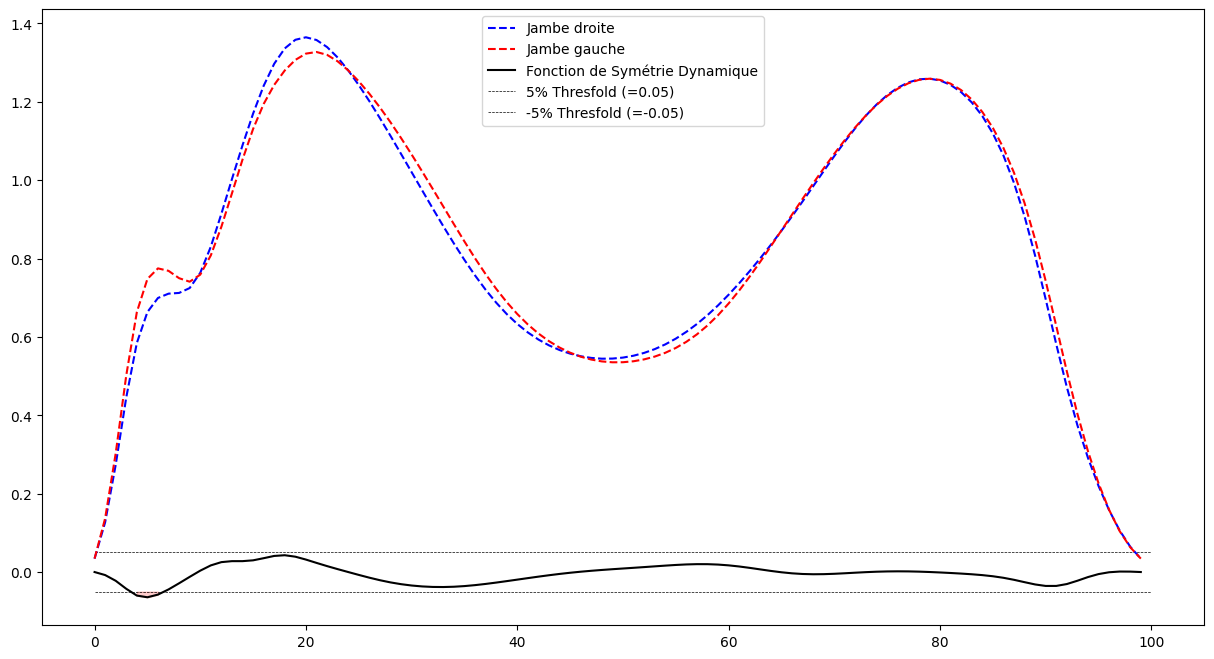

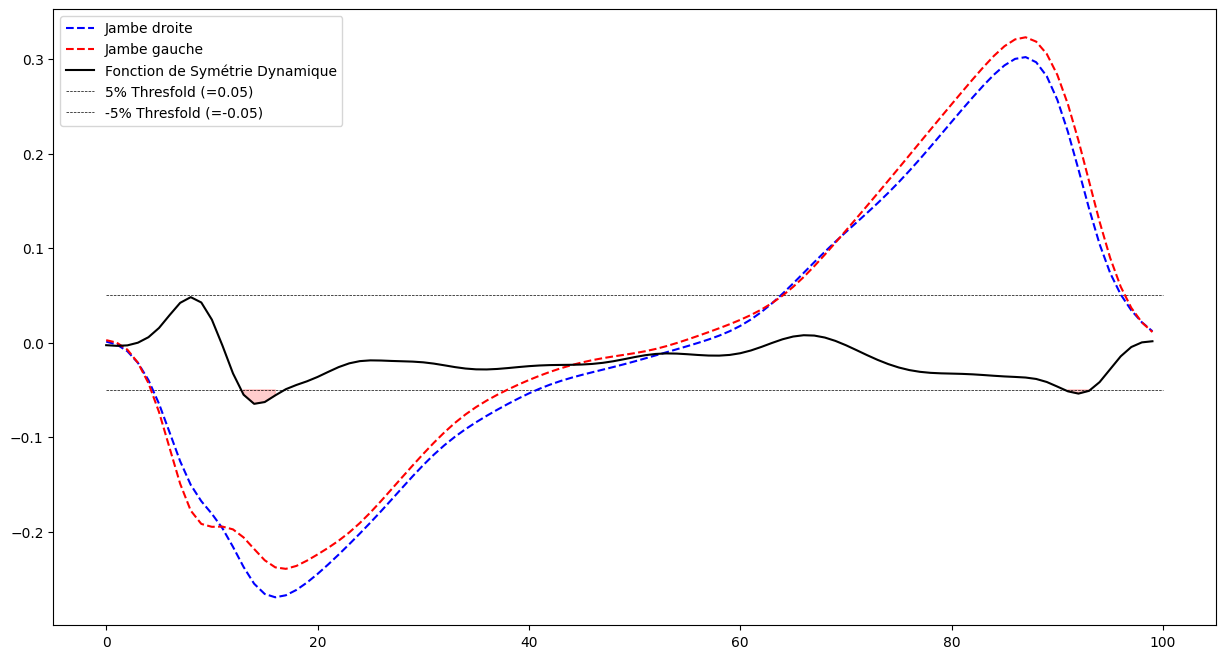

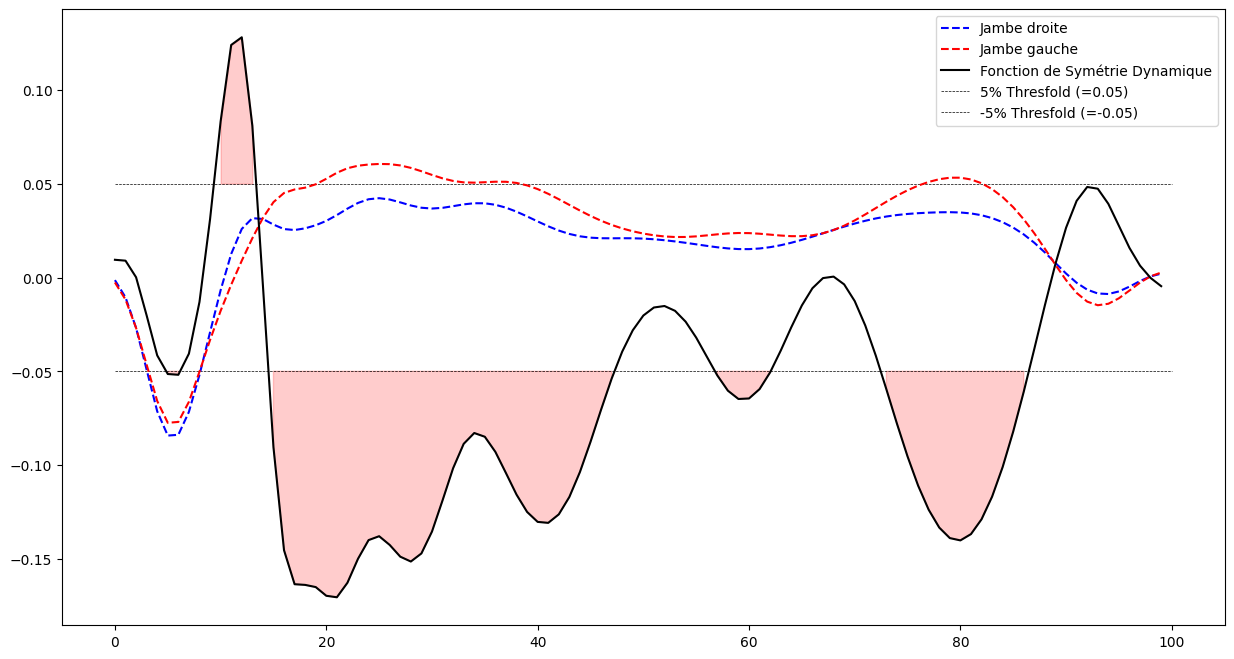

In [17]:
from Walking.WalkingFilters import WalkingGraphicsFilter
from Walking.WalkingGraphicsProcedure import PlotDynamicSymetryFunctionNormalisedProcedure

procedure = PlotDynamicSymetryFunctionNormalisedProcedure()
WalkingGraphicsFilter(walking, procedure).run()